In [2]:
!pip install tensorflow_text

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4460,spam,Welcome to UK-mobile-date this msg is FREE giv...,1
673,spam,Get ur 1st RINGTONE FREE NOW! Reply to this ms...,1
1263,spam,"Hungry gay guys feeling hungry and up 4 it, no...",1
474,spam,Want 2 get laid tonight? Want real Dogging loc...,1
1022,spam,Guess what! Somebody you know secretly fancies...,1


<h4>Split it into training and test data set</h4>

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [15]:
X_train.head(4)

4834    New Mobiles from 2004, MUST GO! Txt: NOKIA to ...
4924                Oh yah... We never cancel leh... Haha
862                              Your brother is a genius
1929    Call from 08702490080 - tells u 2 call 0906635...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [106]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2")

In [107]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 0.9959294 ,  0.54937845, -0.17059089,  0.9307302 , -0.839425  ,
        -0.8062609 ,  0.10320493, -0.01254707, -0.8349162 ,  0.62639236,
         0.99062604, -0.9572671 ,  0.00416147, -0.16611162, -0.7415951 ,
         0.46616432,  0.13030398, -0.548481  , -0.5582348 ,  0.20466858,
        -0.8795259 ,  0.99975425,  0.35159498,  0.9977597 , -0.8877576 ,
        -0.29746315,  0.17751692, -0.8887875 ,  0.3549734 ,  0.44167557,
         0.97313184,  0.99551433,  0.07530776,  0.00141761,  0.19440353,
         0.20965397, -0.94448465, -0.998574  , -0.87515855, -0.5595215 ,
         0.99755085, -0.88181096,  0.9432055 ,  0.00786559,  0.33160868,
         0.4868377 , -0.96451974, -0.95495576,  0.56235754,  0.73849654,
         0.9703344 ,  0.7244811 ,  0.95124215, -0.8161786 , -0.0873585 ,
        -0.86492723,  0.7111206 , -0.865234  ,  0.06383545,  0.9884006 ,
         0.8626445 ,  0.9800195 ,  0.99111575, -0.10390419,  0.4424442 ,
 

<h4>Build Model</h4>

There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [113]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [114]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'default': (None, 1 6368641     keras_layer_2[1][0]              
                                                                 keras_layer_2[1][1]              
                                                                 keras_layer_2[1][2]              
____________________________________________________________________________________________

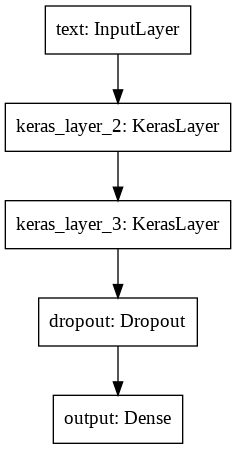

In [115]:
tf.keras.utils.plot_model(model)

In [116]:
len(X_train)

1120

In [119]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [120]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
35/35 [==============================] - 9s 176ms/step - loss: 0.2400 - accuracy: 0.9286 - precision: 0.9211 - recall: 0.9375
Epoch 2/20
35/35 [==============================] - 6s 177ms/step - loss: 0.2258 - accuracy: 0.9277 - precision: 0.9331 - recall: 0.9214
Epoch 3/20
35/35 [==============================] - 6s 172ms/step - loss: 0.2224 - accuracy: 0.9330 - precision: 0.9292 - recall: 0.9375
Epoch 4/20
35/35 [==============================] - 6s 173ms/step - loss: 0.2107 - accuracy: 0.9214 - precision: 0.9055 - recall: 0.9411
Epoch 5/20
35/35 [==============================] - 6s 172ms/step - loss: 0.2081 - accuracy: 0.9330 - precision: 0.9277 - recall: 0.9393
Epoch 6/20
35/35 [==============================] - 6s 171ms/step - loss: 0.2010 - accuracy: 0.9259 - precision: 0.9221 - recall: 0.9304
Epoch 7/20
35/35 [==============================] - 6s 171ms/step - loss: 0.2047 - accuracy: 0.9304 - precision: 0.9199 - recall: 0.9429
Epoch 8/20
35/35 [=======================

In [76]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 8s 597ms/step - loss: 0.2415 - accuracy: 0.9251 - precision: 0.8878 - recall: 0.9733


[0.24146045744419098,
 0.9251337051391602,
 0.8878048658370972,
 0.9732620120048523]

In [77]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [78]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,

In [79]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[164,  23],
       [  5, 182]])

Text(33.0, 0.5, 'Truth')

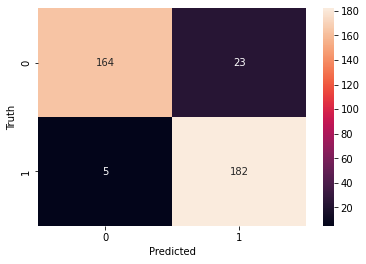

In [80]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [81]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       187
           1       0.89      0.97      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.92       374
weighted avg       0.93      0.93      0.92       374



<h4>Inference</h4>

In [82]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "Hi. Your loan amount for Rs.70000.00/- is successfully approved."
]
model.predict(reviews)

array([[0.8444062 ],
       [0.91063744],
       [0.8796493 ],
       [0.31810027],
       [0.12575856],
       [0.7018306 ]], dtype=float32)

In [130]:
model.save('spam_mod_1.h5')

In [127]:
tf.keras.models.save_model(model, "spam_keras_bert")

INFO:tensorflow:Assets written to: spam_keras_bert/assets


INFO:tensorflow:Assets written to: spam_keras_bert/assets


In [131]:
new_model = tf.keras.models.load_model("spam_mod_1.h5", custom_objects={'KerasLayer':hub.KerasLayer})

In [128]:
reloaded_model = tf.keras.models.load_model('spam_keras_bert')

In [132]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'sequence_output':  6368641     keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
____________________________________________________________________________________________